# Tako HRM - Training

Train the Hierarchical Reasoning Model (HRM) on different games using self-play RL.

## Games

- **TicTacToe** - Simple 3x3 game (1.1M params, ~30min to convergence)
- **Othello** - 8x8 board (8.4M params, ~2-3 hours)
- **Hex** - 11x11 board (Coming soon)
- **Chess** - Full chess (27M params, requires pretraining)

---

## Verify Setup

**Run `setup.ipynb` first if you haven't already!**

In [2]:
# Check GPU availability
import torch
import os

if torch.cuda.is_available():
    device = 'cuda'
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"\n   Note: Ray workers will share GPU using fractional allocation")
else:
    device = 'cpu'
    print("⚠️  No GPU detected - training will be slower")
    print("   Enable: Runtime → Change runtime type → GPU")

os.chdir('/content/tako-v2')

✅ GPU: NVIDIA L4
   Memory: 23.7 GB

   Note: Ray workers will share GPU using fractional allocation


---

## Tic-Tac-Toe Training
 
 

In [3]:
os.listdir('checkpoints/tictactoe')
folder_path = 'checkpoints/tictactoe'

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path) # os.unlink() is a synonym for os.remove()
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path) # Recursively remove subdirectories
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

In [ ]:
GAME = "tictactoe"
CONFIG = f"config/{GAME}.yaml"
EPOCHS = 10
CHECKPOINT = "/content/drive/MyDrive/tako_checkpoints/tictactoe/checkpoint_22500.pt"
device = 'mps'
print(f"Training: {GAME}")
print(f"Config: {CONFIG}")
print(f"Epochs: {EPOCHS}")
print("\n" + "="*80)

# import os; os.chdir('/Users/zfdupont/tako-v2')
import os; os.chdir('/content/tako-v2')
# Start training
!uv run python scripts/train.py --config {CONFIG} --epochs {EPOCHS} --num-workers 2 

Training: tictactoe
Config: config/tictactoe.yaml
Epochs: 10

✅ FlashAttention (SDPA) enabled
[Train] Starting Tako training
[Train] Game: tictactoe
[Train] Config: config/tictactoe.yaml
[Train] Device: cuda
[Train] Workers: 2
[Train] Games per worker: 100
[Train] Detected 1 CUDA GPU(s)
[Train]   GPU 0: NVIDIA L4
2026-02-26 06:53:44,664	INFO worker.py:2004 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2026-02-26 06:53:44,666	WARNING working_dir.py:86 -- Directory '.git' is now ignored by default when packaging the working directory. To disable this behavior, set the `RAY_OVERRIDE_RUNTIME_ENV_DEFAULT_EXCLUDES=''` environment variable.
2026-02-26 06:53:44,667	WARNING working_dir.py:86 -- Directory '.venv' is now ignored by default when packaging the working directory. To disable this behavior, set the `RAY_OVERRIDE_RUNTIME_ENV_DEFAULT_EXCLUDES=''` environment variable.
2026-02-26 06:53:44,672	INFO packaging.py:392 -- Ignoring upload to cluster for these fi

: 

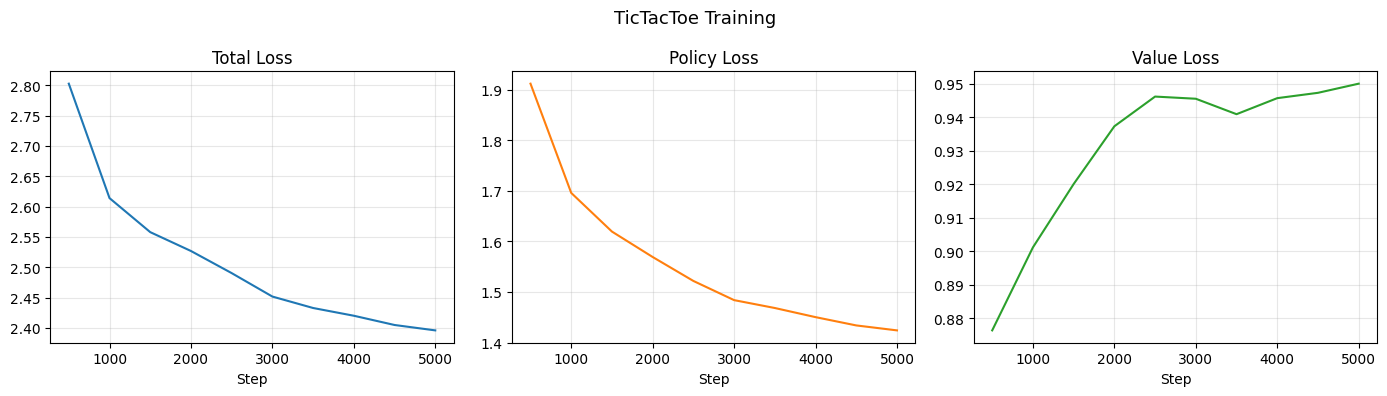

✅ 10 epochs — latest total loss: 2.3959


In [6]:
# Plot training curves
import json
import matplotlib.pyplot as plt
from pathlib import Path

metrics_file = Path(f'logs/tictactoe/metrics.json')
if metrics_file.exists():
    with open(metrics_file) as f:
        metrics = json.load(f)

    if metrics:
        steps         = [m['step'] for m in metrics]
        total_losses  = [m['losses']['total_loss'] for m in metrics]
        policy_losses = [m['losses']['policy_loss'] for m in metrics]
        value_losses  = [m['losses']['value_loss'] for m in metrics]

        fig, axes = plt.subplots(1, 3, figsize=(14, 4))

        axes[0].plot(steps, total_losses, linewidth=1.5)
        axes[0].set_title('Total Loss')
        axes[0].set_xlabel('Step'); axes[0].grid(True, alpha=0.3)

        axes[1].plot(steps, policy_losses, linewidth=1.5, color='tab:orange')
        axes[1].set_title('Policy Loss')
        axes[1].set_xlabel('Step'); axes[1].grid(True, alpha=0.3)

        axes[2].plot(steps, value_losses, linewidth=1.5, color='tab:green')
        axes[2].set_title('Value Loss')
        axes[2].set_xlabel('Step'); axes[2].grid(True, alpha=0.3)

        plt.suptitle('TicTacToe Training', fontsize=13)
        plt.tight_layout()
        plt.show()
        print(f"✅ {len(metrics)} epochs — latest total loss: {total_losses[-1]:.4f}")
    else:
        print("⚠️  metrics.json is empty")
else:
    print(f"⚠️  {metrics_file} not found — run training first")

---

## Othello Training

**Model:** 8.4M parameters  
**Time:** ~2-3 hours to competent play  
**Target:** Beat Edax level 3

In [ ]:
# Othello training configuration
GAME = "othello"
CONFIG = f"config/{GAME}.yaml"
EPOCHS = 10

print(f"Training: {GAME}")
print(f"Config: {CONFIG}")
print(f"Epochs: {EPOCHS}")
print(f"Device: {device}")
print("\n" + "="*80)

# Start training
!uv run python scripts/train.py --config {CONFIG} --epochs {EPOCHS}

### Monitor Othello Progress

In [ ]:
# Plot training curves
import json
import matplotlib.pyplot as plt
from pathlib import Path

metrics_file = Path('logs/othello/metrics.json')
if metrics_file.exists():
    with open(metrics_file) as f:
        metrics = json.load(f)

    if metrics:
        steps         = [m['step'] for m in metrics]
        total_losses  = [m['losses']['total_loss'] for m in metrics]
        policy_losses = [m['losses']['policy_loss'] for m in metrics]
        value_losses  = [m['losses']['value_loss'] for m in metrics]

        fig, axes = plt.subplots(1, 3, figsize=(14, 4))

        axes[0].plot(steps, total_losses, linewidth=1.5)
        axes[0].set_title('Total Loss')
        axes[0].set_xlabel('Step'); axes[0].grid(True, alpha=0.3)

        axes[1].plot(steps, policy_losses, linewidth=1.5, color='tab:orange')
        axes[1].set_title('Policy Loss')
        axes[1].set_xlabel('Step'); axes[1].grid(True, alpha=0.3)

        axes[2].plot(steps, value_losses, linewidth=1.5, color='tab:green')
        axes[2].set_title('Value Loss')
        axes[2].set_xlabel('Step'); axes[2].grid(True, alpha=0.3)

        plt.suptitle('Othello Training', fontsize=13)
        plt.tight_layout()
        plt.show()
        print(f"✅ {len(metrics)} epochs — latest total loss: {total_losses[-1]:.4f}")
    else:
        print("⚠️  metrics.json is empty")
else:
    print(f"⚠️  {metrics_file} not found — run training first")

---

## Hex Training

**Model:** ~8M parameters  
**Time:** ~3-4 hours  
**Target:** Strong tactical play on 11x11 board

In [ ]:
# Hex training configuration
GAME = "hex"
CONFIG = f"config/{GAME}.yaml"
EPOCHS = 10

print(f"Training: {GAME}")
print(f"Config: {CONFIG}")
print(f"Epochs: {EPOCHS}")
print(f"Device: {device}")
print("\n" + "="*80)

# Start training
!uv run python scripts/train.py --config {CONFIG} --epochs {EPOCHS}

---

## Chess Training

**Model:** 27M parameters  
**Time:** Days (requires pretraining)  
**Target:** 2500+ Elo (GM level)

**Note:** Chess requires supervised pretraining on PGN data before self-play.

In [ ]:
# Chess pretraining (run first)
print("Chess pretraining...")
print("This requires PGN data in data/chess/")
print("\n" + "="*80)

!uv run python scripts/pretrain.py --config config/chess.yaml --data data/chess/games.pgn

In [ ]:
# Chess self-play training (run after pretraining)
GAME = "chess"
CONFIG = f"config/{GAME}.yaml"
EPOCHS = 20
RESUME = "checkpoints/chess/pretrain_final.pt"  # Load pretrained checkpoint

print(f"Training: {GAME}")
print(f"Config: {CONFIG}")
print(f"Resume from: {RESUME}")
print(f"Epochs: {EPOCHS}")
print(f"Device: {device}")
print("\n" + "="*80)

# Start training
!uv run python scripts/train.py --config {CONFIG} --epochs {EPOCHS} --resume {RESUME}

---

## List Checkpoints

In [ ]:
# List all checkpoints
from pathlib import Path
import datetime

checkpoint_dir = Path('checkpoints')

if checkpoint_dir.exists():
    for game_dir in sorted(checkpoint_dir.iterdir()):
        if game_dir.is_dir():
            checkpoints = sorted(game_dir.glob('*.pt'), key=lambda p: p.stat().st_mtime)
            if checkpoints:
                print(f"\n{game_dir.name.upper()}:")
                print("="*80)
                for ckpt in checkpoints[-5:]:  # Show last 5
                    size_mb = ckpt.stat().st_size / 1e6
                    mtime = datetime.datetime.fromtimestamp(ckpt.stat().st_mtime)
                    print(f"  {ckpt.name:<40} {size_mb:>6.1f} MB   {mtime.strftime('%Y-%m-%d %H:%M:%S')}")
                print(f"  Latest: {checkpoints[-1].name}")
else:
    print("⚠️  No checkpoints found")